In [1]:
import importlib
import sys
import torch
import pickle
import os
import pandas as pd

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

from aa_philipp.model_with_integrated_gradients.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

In [2]:
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)


In [3]:
#load model

file_path_model = '../../notebooks/training_variational_dropout/Helpdesk/Helpdesk_full_grad_norm_philipp_4layer.pkl'
model = DropoutUncertaintyEncoderDecoderLSTM.load(file_path_model, dropout=0.0)

# Load the dataset
file_path_data_set = '../../../encoded_data/test_philipp/helpdesk_all_5_test.pkl'
helpdesk_test_dataset = torch.load(file_path_data_set, weights_only=False)

Data set categories:  ([('Activity', 16, {'Assign seriousness': 1, 'Closed': 2, 'Create SW anomaly': 3, 'DUPLICATE': 4, 'EOS': 5, 'INVALID': 6, 'Insert ticket': 7, 'RESOLVED': 8, 'Require upgrade': 9, 'Resolve SW anomaly': 10, 'Resolve ticket': 11, 'Schedule intervention': 12, 'Take in charge ticket': 13, 'VERIFIED': 14, 'Wait': 15}), ('Resource', 24, {'EOS': 1, 'Value 1': 2, 'Value 10': 3, 'Value 11': 4, 'Value 12': 5, 'Value 13': 6, 'Value 14': 7, 'Value 15': 8, 'Value 16': 9, 'Value 17': 10, 'Value 18': 11, 'Value 19': 12, 'Value 2': 13, 'Value 20': 14, 'Value 21': 15, 'Value 22': 16, 'Value 3': 17, 'Value 4': 18, 'Value 5': 19, 'Value 6': 20, 'Value 7': 21, 'Value 8': 22, 'Value 9': 23}), ('Variant index', 175, {'1.0': 1, '10.0': 2, '100.0': 3, '103.0': 4, '104.0': 5, '107.0': 6, '109.0': 7, '11.0': 8, '110.0': 9, '112.0': 10, '113.0': 11, '114.0': 12, '115.0': 13, '117.0': 14, '118.0': 15, '12.0': 16, '120.0': 17, '122.0': 18, '123.0': 19, '124.0': 20, '125.0': 21, '126.0': 22, '1

In [4]:

import evaluation.evaluation
importlib.reload(evaluation.evaluation)
from evaluation.evaluation import Evaluation


new_eval = Evaluation(model=model, 
                                   dataset=helpdesk_test_dataset,
                                   concept_name='Activity',
                                   #growing_num_values = [],
                                   growing_num_values = ['case_elapsed_time'],
                                   all_cat=['Activity', 'Resource'],
                                   all_num=['case_elapsed_time', 'event_elapsed_time'])


cases = new_eval._get_cases_from_dataset()

case_items = list(new_eval.cases.items())




# Integrated Gradients

In [5]:
from captum.attr import IntegratedGradients

from model_with_integrated_gradients.dropout_uncertainty_decoder_forward_simplified import PSP_Model_simplified

from typing import Callable, Optional, Tuple


def forward_for_ig(
    model,
    prefix: torch.Tensor,
    target_fn: Callable,
):  
    simplified_model = PSP_Model_simplified(model=model)
    predictions = simplified_model.forward(prefix=prefix)
    
    target = target_fn(predictions)

    return target

In [ ]:

from model_with_integrated_gradients.embedder import get_final_process_step


def compute_integrated_gradients(
    model,
    prefix,
    target_fn: Callable,
    n_steps: int = 50,
):
    """
    Returns:
        attributions: Tensor same shape as encoder input
    """

    # Encode prefix as model input

    prefixes_embedded = model.encoder.data_enc_for_model(data=prefix)
    prefixes_embedded = prefixes_embedded.detach()
    prefixes_embedded.requires_grad_(True)

    sos_event = get_final_process_step(prefix)

    final_prefix_element_embedded = model.decoder.data_enc_for_model(data=sos_event, pred = False)
    final_prefix_element_embedded = final_prefix_element_embedded.detach()
    final_prefix_element_embedded.requires_grad_(True)

    
    baselines = (torch.tensor([0.0]), torch.tensor([0.0]))
    
    ig = IntegratedGradients(
        lambda x1,x2: forward_for_ig(
            model=model,
            prefix=(x1,x2),
            target_fn=target_fn,
        )
    )

    attributions = ig.attribute(
        inputs=(prefixes_embedded, final_prefix_element_embedded),
        baselines=baselines,
        n_steps=n_steps,
    )
    
    attributions[0][17, :, :19] += attributions[1][0]
    
    return attributions[0]


In [9]:
def full_forward(prefix):
    # Encode prefix as model input
        prefixes_embedded = model.encoder.data_enc_for_model(data=prefix)
        prefixes_embedded = prefixes_embedded.detach()
        prefixes_embedded.requires_grad_(True)


        cat_prefixes, num_prefixes = prefix
        cat_sos_events = [cat_tens[:, -1:] for cat_tens in cat_prefixes]
        num_sos_events = [num_tens[:, -1:] for num_tens in num_prefixes]
        sos_event = [cat_sos_events, num_sos_events]

        final_prefix_element_embedded = model.decoder.data_enc_for_model(data=sos_event, pred = False)
        final_prefix_element_embedded = final_prefix_element_embedded.detach()
        final_prefix_element_embedded.requires_grad_(True)

        pred = forward_for_ig(
            model=model,
            prefix=(prefixes_embedded,final_prefix_element_embedded),
            target_fn=lambda x:x,
        )
        return pred

In [ ]:
from tqdm import tqdm
from model_with_integrated_gradients.targeter import ActivityTargeter, TimeTargeter

torch.set_printoptions(sci_mode=False)

results_rows = []
for i, (case_name, full_case) in enumerate(tqdm(case_items)):
    for j, (prefix_len, prefix, suffix) in enumerate(new_eval._iterate_case(full_case)):
        
        time_targeter = TimeTargeter()

        attributions_case_elapsed_time = compute_integrated_gradients(
            model=model,
            prefix=prefix,
            target_fn=time_targeter.target_fn,
            n_steps=20
        )

        pred = full_forward(prefix)
        
        activity_prediction = pred[0][0]["Activity_mean"][0].argmax()
        activity_targeter = ActivityTargeter(activity_index=activity_prediction)
        
        attributions_predicted_activity = compute_integrated_gradients(
            model=model,
            prefix=prefix,
            target_fn=activity_targeter.target_fn, 
            n_steps=20
        )

        row = {
            'case_name': case_name,
            'prefix_len':prefix_len,
            'attributions_case_elapsed_time': attributions_case_elapsed_time,
            "attributions_predicted_activity":attributions_predicted_activity,
        }

        results_rows.append(row)

results_df = pd.DataFrame(results_rows)


  1%|          | 9/916 [00:49<1:22:24,  5.45s/it]


KeyboardInterrupt: 

In [ ]:
def sample_suffix(self, prefix, prefix_len, include_model_states):
        
        prediction, (h, c), z = self.model.inference(prefix=prefix)

        suffix = []
        max_iteration = (
            self.dataset.encoder_decoder.window_size
            - self.dataset.encoder_decoder.min_suffix_size
            - prefix_len
        )

        last_means = {
            a + "_mean": prefix[1][self.all_num_attributes.index(a)][:, -1].unsqueeze(1)
            for a in self.growing_num_values
        }

        cat_predictions = self.sample_cat_predictions(
            prediction[0][0], prediction[1][0]
        )
        num_predictions = self.sample_num_predictions(
            prediction[0][1], prediction[1][1], last_means
        )

        if include_model_states:
            model_states = []

        i = 0
        eos_predicted = (
            lambda: cat_predictions[self.concept_name + "_mean"] == self.eos_id
        )
        while i <= max_iteration and not eos_predicted():

            
            prediction, (h, c) = self.model.inference(
                last_event=(
                    list(cat_predictions.values()),
                    list(num_predictions.values()),
                ),
                hx=(h, c),
                z=None,
            )

            cat_predictions = self.sample_cat_predictions(
                prediction[0][0], prediction[1][0]
            )
            num_predictions = self.sample_num_predictions(
                prediction[0][1], prediction[1][1], last_means
            )

            i += 1

        if include_model_states:
            return suffix, model_states
        else:
            return suffix

'from tqdm import tqdm\n\ntorch.set_printoptions(sci_mode=False)\n\nresults_rows = []\nfor i, (case_name, full_case) in enumerate(tqdm(case_items)):\n    for j, (prefix_len, prefix, suffix) in enumerate(new_eval._iterate_case(full_case)):\n        attributions_case_elapsed_time = compute_integrated_gradients(\n            model=model,\n            prefix=prefix,\n            target_fn=target_fn_case_elapsed_time_mean,\n            baselines=None,     # defaults to zero embedding\n            n_steps=20\n        )\n\n        attributions_predicted_activity = compute_integrated_gradients(\n            model=model,\n            prefix=prefix,\n            target_fn=lambda x: target_fn_activity(x), \n            baselines=None,    # defaults to zero embedding\n            n_steps=20\n        )\n\n        row = {\n            \'case_name\': case_name,\n            \'prefix_len\':prefix_len,\n            \'attributions_case_elapsed_time\': attributions_case_elapsed_time,\n            "attrib

In [ ]:

results_df = pd.DataFrame(results_rows)


with open ("results_store_integrated_gradients_helpdesk_on_case_elapsed_time_and_attributions_predicted_activity.pkl", "wb") as f:
   pickle.dump(results_df,f)

In [ ]:
import pickle
import pandas as pd

with open ("results_store_integrated_gradients_helpdesk_on_case_elapsed_time_and_attributions_predicted_activity.pkl", "rb") as f:
    results_df = pickle.load(f)

results_df = pd.DataFrame(results_df)

In [ ]:
results_df.head()

,case_name,prefix_len,attributions_case_elapsed_time,attributions_predicted_activity
0,Case 1016,1,"[[[tensor(-0.0002, grad_fn=<UnbindBackward0>),...","[[[tensor(0.0002, grad_fn=<UnbindBackward0>), ..."
1,Case 1016,2,"[[[tensor(-0.0059, grad_fn=<UnbindBackward0>),...","[[[tensor(-0.0097, grad_fn=<UnbindBackward0>),..."
2,Case 1016,3,"[[[tensor(-0.0132, grad_fn=<UnbindBackward0>),...","[[[tensor(-0.0245, grad_fn=<UnbindBackward0>),..."
3,Case 102,1,"[[[tensor(-0.0001, grad_fn=<UnbindBackward0>),...","[[[tensor(0.0000, grad_fn=<UnbindBackward0>), ..."
4,Case 102,2,"[[[tensor(-0.0055, grad_fn=<UnbindBackward0>),...","[[[tensor(-0.0134, grad_fn=<UnbindBackward0>),..."


In [ ]:
results_df.loc[0,"attributions_predicted_activity"][1].max()



tensor(0.0005, grad_fn=<MaxBackward1>)

In [ ]:
import pickle

with open("results_store_helpdesk_results.pkl", "rb") as f:
    inference_results = pickle.load(f)

inference_results = pd.DataFrame(inference_results)

In [ ]:

len(results_df["attributions_case_elapsed_time"][0][-1][0])

131

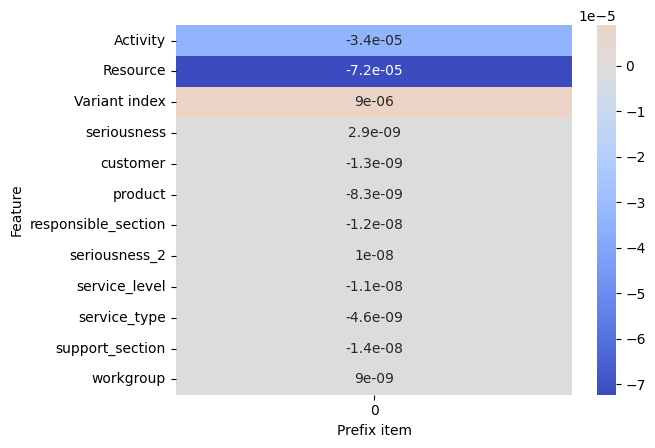

Timestep 1           Timestep 2
Prefix          Activity              Assign seriousness                  NaN
                Resource                         Value 8                  NaN
                Variant index                        1.0                  NaN
                seriousness                         None                  NaN
                customer                         Value 8                  NaN
                product                          Value 3                  NaN
                responsible_section              Value 1                  NaN
                seriousness_2                    Value 2                  NaN
                service_level                    Value 2                  NaN
                service_type                     Value 2                  NaN
                support_section                  Value 1                  NaN
                workgroup                        Value 2                  NaN
                case_elapsed_time               0.070602                  NaN
                event_elapsed_time           963303.3125                  NaN
                day_in_week                          2.0                  NaN
                seconds_in_day              27781.000034                  NaN
Mean Prediction Activity                  Resolve ticket               Closed
                Resource                         Value 2              Value 5
                case_elapsed_time    [621611.2774808262]   [2210891.81877661]
                event_elapsed_time   [397517.0850068639]  [1235720.503316847]

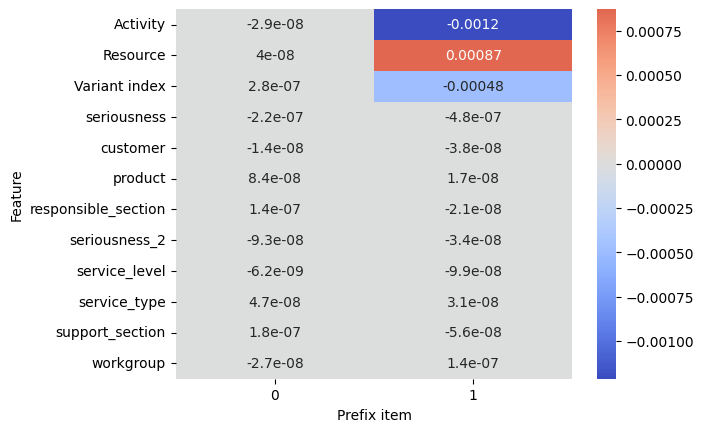

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 8   
                Variant index                        1.0   
                seriousness                         None   
                customer                         Value 8   
                product                          Value 3   
                responsible_section              Value 1   
                seriousness_2                    Value 2   
                service_level                    Value 2   
                service_type                     Value 2   
                support_section                  Value 1   
                workgroup                        Value 2   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                          2.0   
                seconds_in_day              27781.000034   
Mean Prediction Activity                  Resolve ticket   
                Resource                         Value 2   
                case_elapsed_time    [1384639.845483871]   
                event_elapsed_time    [571136.471680579]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 8  
                Variant index                          1.0  
                seriousness                           None  
                customer                           Value 8  
                product                            Value 3  
                responsible_section                Value 1  
                seriousness_2                      Value 2  
                service_level                      Value 2  
                service_type                       Value 2  
                support_section                    Value 1  
                workgroup                          Value 2  
                case_elapsed_time               149.029932  
                event_elapsed_time              148.938768  
                day_in_week                            2.0  
                seconds_in_day                27930.000029  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time     [3062353.2753566504]  
                event_elapsed_time    [1553601.3462951765]

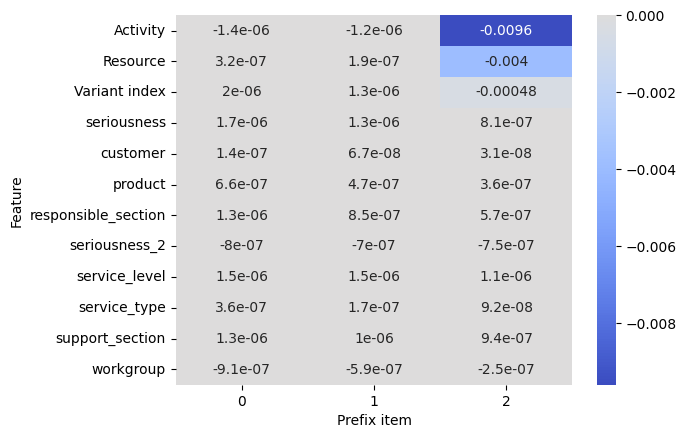

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 8   
                Variant index                         1.0   
                seriousness                          None   
                customer                          Value 8   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                     Value 2   
                service_level                     Value 2   
                service_type                      Value 2   
                support_section                   Value 1   
                workgroup                         Value 2   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               27781.000034   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3243812.4449958922]   
                event_elapsed_time   [1655798.5871834268]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 8        Value 16  
                Variant index                          1.0             1.0  
                seriousness                           None            None  
                customer                           Value 8         Value 8  
                product                            Value 3         Value 3  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 2         Value 2  
                service_level                      Value 2         Value 2  
                service_type                       Value 2         Value 2  
                support_section                    Value 1         Value 1  
                workgroup                          Value 2         Value 2  
                case_elapsed_time               149.029932    26071.995951  
                event_elapsed_time              148.938768     25922.95599  
                day_in_week                            2.0             2.0  
                seconds_in_day                27930.000029    53852.999749  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

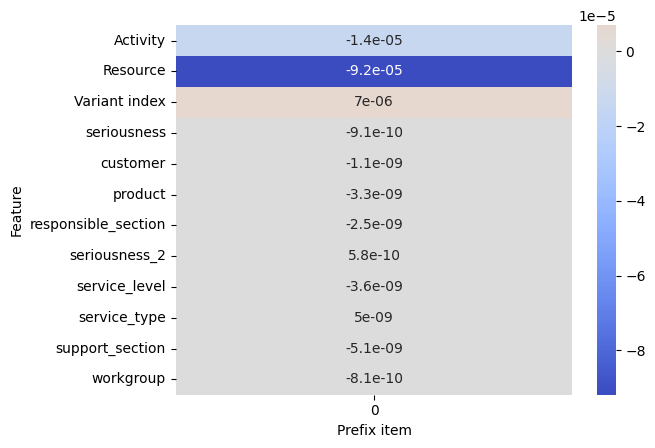

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 4   
                Variant index                          1.0   
                seriousness                           None   
                customer                          Value 62   
                product                            Value 3   
                responsible_section                Value 1   
                seriousness_2                         None   
                service_level                      Value 1   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                           -0.0   
                seconds_in_day                32969.000248   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time      [597701.0999177805]   
                event_elapsed_time     [411993.6227594345]   

                                               Timestep 2  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                Variant index                         NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1341525.3985874555]   
                event_elapsed_time    [581219.7089496164]   

                                               Timestep 3  
Prefix          Activity                              NaN  
                Resource                              NaN  
                Variant index                         NaN  
                seriousness                           NaN  
                customer                              NaN  
                product                               NaN  
                responsible_section                   NaN  
                seriousness_2                         NaN  
                service_level                         NaN  
                service_type                          NaN  
                support_section                       NaN  
                workgroup                             NaN  
                case_elapsed_time                     NaN  
                event_elapsed_time                    NaN  
                day_in_week                           NaN  
                seconds_in_day                        NaN  
Mean Prediction Activity                           Closed  
                Resource                          Value 5  
                case_elapsed_time     [3005770.044605284]  
                event_elapsed_time   [1512819.2595552616]

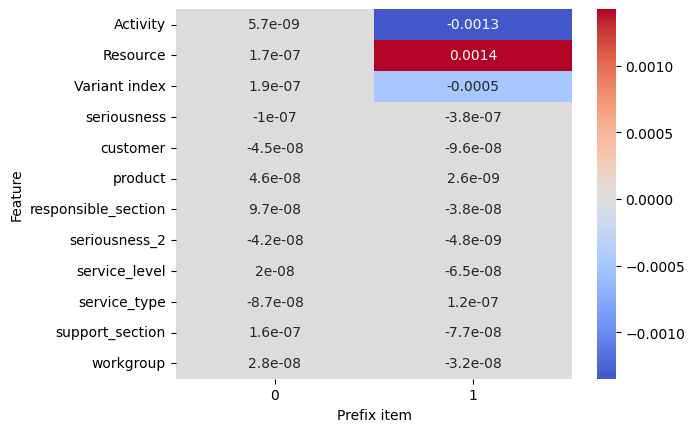

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 4   
                Variant index                         1.0   
                seriousness                          None   
                customer                         Value 62   
                product                           Value 3   
                responsible_section               Value 1   
                seriousness_2                        None   
                service_level                     Value 1   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                          -0.0   
                seconds_in_day               32969.000248   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1547279.7156224363]   
                event_elapsed_time    [660201.8935342438]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 4  
                Variant index                          1.0  
                seriousness                           None  
                customer                          Value 62  
                product                            Value 3  
                responsible_section                Value 1  
                seriousness_2                         None  
                service_level                      Value 1  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time                28.000476  
                event_elapsed_time               27.995833  
                day_in_week                           -0.0  
                seconds_in_day                32997.000329  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time      [3097246.386069461]  
                event_elapsed_time    [1548098.6269628315]

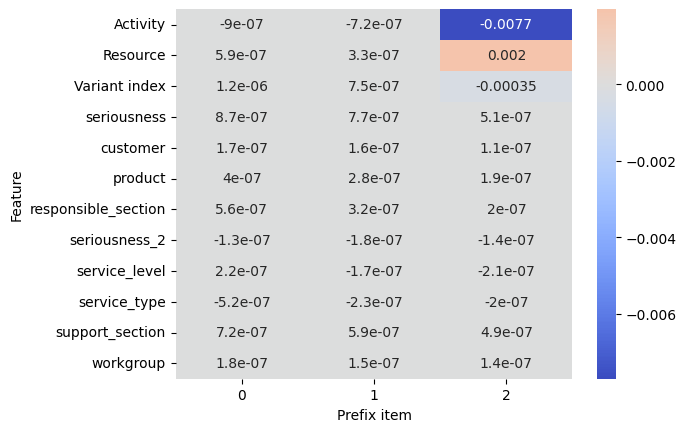

Timestep 1  \
Prefix          Activity              Assign seriousness   
                Resource                         Value 4   
                Variant index                        1.0   
                seriousness                         None   
                customer                        Value 62   
                product                          Value 3   
                responsible_section              Value 1   
                seriousness_2                       None   
                service_level                    Value 1   
                service_type                     Value 1   
                support_section                  Value 1   
                workgroup                        Value 1   
                case_elapsed_time               0.070602   
                event_elapsed_time           963303.3125   
                day_in_week                         -0.0   
                seconds_in_day              32969.000248   
Mean Prediction Activity                          Closed   
                Resource                         Value 5   
                case_elapsed_time    [3234048.258869862]   
                event_elapsed_time   [1624277.800128834]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 4         Value 2  
                Variant index                          1.0             1.0  
                seriousness                           None            None  
                customer                          Value 62        Value 62  
                product                            Value 3         Value 3  
                responsible_section                Value 1         Value 1  
                seriousness_2                         None            None  
                service_level                      Value 1         Value 1  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time                28.000476    82957.065346  
                event_elapsed_time               27.995833    82928.989434  
                day_in_week                           -0.0             1.0  
                seconds_in_day                32997.000329    29526.000295  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

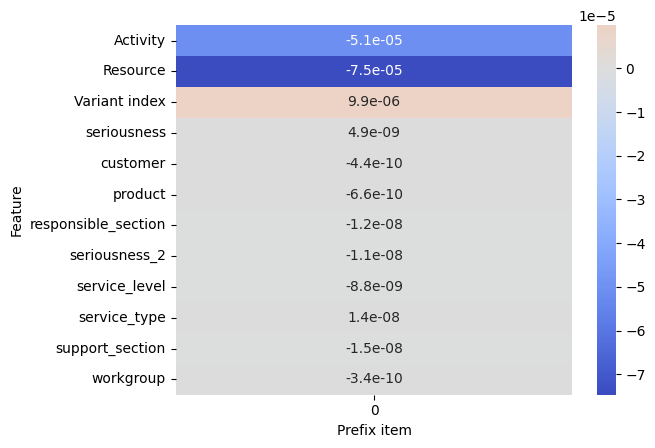

Timestep 1  \
Prefix          Activity                Assign seriousness   
                Resource                           Value 1   
                Variant index                          2.0   
                seriousness                           None   
                customer                          Value 71   
                product                            Value 1   
                responsible_section                Value 1   
                seriousness_2                      Value 1   
                service_level                      Value 3   
                service_type                       Value 1   
                support_section                    Value 1   
                workgroup                          Value 1   
                case_elapsed_time                 0.070602   
                event_elapsed_time             963303.3125   
                day_in_week                            2.0   
                seconds_in_day                54444.999721   
Mean Prediction Activity             Take in charge ticket   
                Resource                           Value 2   
                case_elapsed_time     [384798.89406331326]   
                event_elapsed_time     [292934.7904828716]   

                                               Timestep 2  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                Variant index                         NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time     [656368.5363040677]   
                event_elapsed_time   [395820.84421969403]   

                                               Timestep 3  \
Prefix          Activity                              NaN   
                Resource                              NaN   
                Variant index                         NaN   
                seriousness                           NaN   
                customer                              NaN   
                product                               NaN   
                responsible_section                   NaN   
                seriousness_2                         NaN   
                service_level                         NaN   
                service_type                          NaN   
                support_section                       NaN   
                workgroup                             NaN   
                case_elapsed_time                     NaN   
                event_elapsed_time                    NaN   
                day_in_week                           NaN   
                seconds_in_day                        NaN   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 5   
                case_elapsed_time    [1868520.5571727792]   
                event_elapsed_time    [982588.1170387521]   

                                               Timestep 4  
Prefix          Activity                              NaN  
                Resource                              NaN  
 

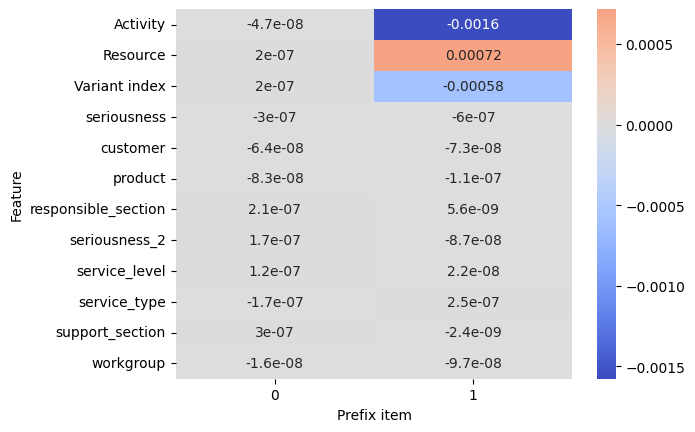

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                Variant index                         2.0   
                seriousness                          None   
                customer                         Value 71   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               54444.999721   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time     [752076.1312557139]   
                event_elapsed_time   [374189.19161585113]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 1  
                Variant index                          2.0  
                seriousness                           None  
                customer                          Value 71  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 3  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time                 9.013061  
                event_elapsed_time                 9.02078  
                day_in_week                            2.0  
                seconds_in_day                54454.000182  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time      [2409053.543365316]  
                event_elapsed_time    [1328207.6753036417]

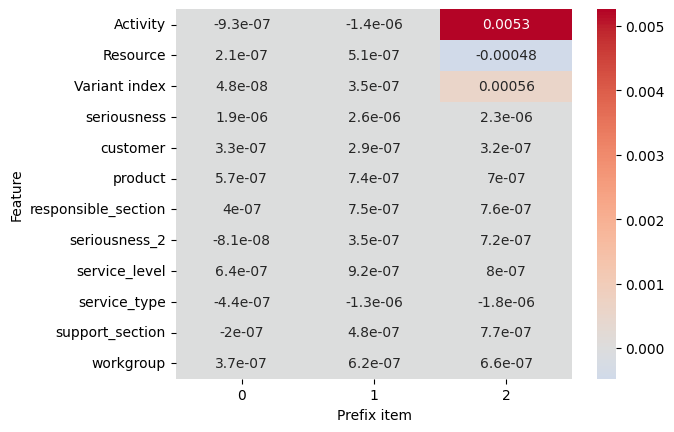

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                Variant index                         2.0   
                seriousness                          None   
                customer                         Value 71   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               54444.999721   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1314664.2705340828]   
                event_elapsed_time    [480133.4988685694]   

                                                Timestep 2     Timestep 3  
Prefix          Activity             Take in charge ticket           None  
                Resource                           Value 1        Value 1  
                Variant index                          2.0            2.0  
                seriousness                           None           None  
                customer                          Value 71       Value 71  
                product                            Value 1        Value 1  
                responsible_section                Value 1        Value 1  
                seriousness_2                      Value 1        Value 1  
                service_level                      Value 3        Value 3  
                service_type                       Value 1        Value 1  
                support_section                    Value 1        Value 1  
                workgroup                          Value 1        Value 1  
                case_elapsed_time                 9.013061  508925.993816  
                event_elapsed_time                 9.02078  508916.996351  
                day_in_week                            2.0            1.0  
                seconds_in_day                54454.000182   44970.999943  
Mean Prediction Activity                            Closed            NaN  
                Resource                           Value 5            NaN  
                case_elapsed_time     [3047806.3432212044]            NaN  
                event_elapsed_time     [1553096.803318705]            NaN

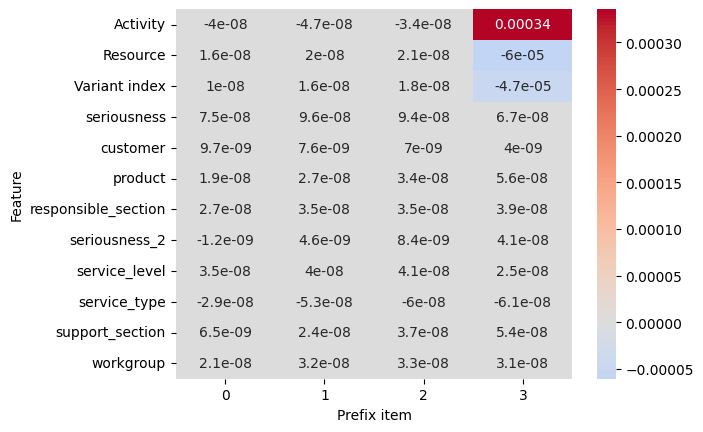

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                Variant index                         2.0   
                seriousness                          None   
                customer                         Value 71   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 3   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           2.0   
                seconds_in_day               54444.999721   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time      [3028923.29806946]   
                event_elapsed_time   [1402033.2280225323]   

                                                Timestep 2     Timestep 3  \
Prefix          Activity             Take in charge ticket           None   
                Resource                           Value 1        Value 1   
                Variant index                          2.0            2.0   
                seriousness                           None           None   
                customer                          Value 71       Value 71   
                product                            Value 1        Value 1   
                responsible_section                Value 1        Value 1   
                seriousness_2                      Value 1        Value 1   
                service_level                      Value 3        Value 3   
                service_type                       Value 1        Value 1   
                support_section                    Value 1        Value 1   
                workgroup                          Value 1        Value 1   
                case_elapsed_time                 9.013061  508925.993816   
                event_elapsed_time                 9.02078  508916.996351   
                day_in_week                            2.0            1.0   
                seconds_in_day                54454.000182   44970.999943   
Mean Prediction Activity                               NaN            NaN   
                Resource                               NaN            NaN   
                case_elapsed_time                      NaN            NaN   
                event_elapsed_time                     NaN            NaN   

                                         Timestep 4  
Prefix          Activity             Resolve ticket  
                Resource                    Value 1  
                Variant index                   2.0  
                seriousness                    None  
                customer                   Value 71  
                product                     Value 1  
                responsible_section         Value 1  
                seriousness_2               Value 1  
                service_level               Value 3  
                service_type                Value 1  
                support_section             Value 1  
                workgroup                   Value 1  
                case_elapsed_time    2928271.992832  
                event_elapsed_time   2419346.063923  
                day_in_week                     1.0  
                seconds_in_day          45116.99993  
Mean Prediction Activity                        NaN  
                Resource                        NaN  
                case_elapsed_time               NaN  
                event_elapsed_time              NaN

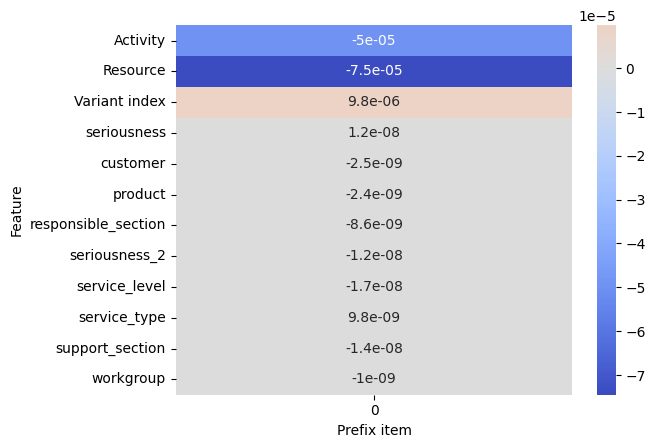

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                Variant index                         1.0   
                seriousness                          None   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day               30142.999905   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time      [648010.337610435]   
                event_elapsed_time   [389500.07903174986]   

                                               Timestep 2  
Prefix          Activity                              NaN  
                Resource                              NaN  
                Variant index                         NaN  
                seriousness                           NaN  
                customer                              NaN  
                product                               NaN  
                responsible_section                   NaN  
                seriousness_2                         NaN  
                service_level                         NaN  
                service_type                          NaN  
                support_section                       NaN  
                workgroup                             NaN  
                case_elapsed_time                     NaN  
                event_elapsed_time                    NaN  
                day_in_week                           NaN  
                seconds_in_day                        NaN  
Mean Prediction Activity                           Closed  
                Resource                          Value 5  
                case_elapsed_time     [2220903.576290213]  
                event_elapsed_time   [1233063.4892725183]

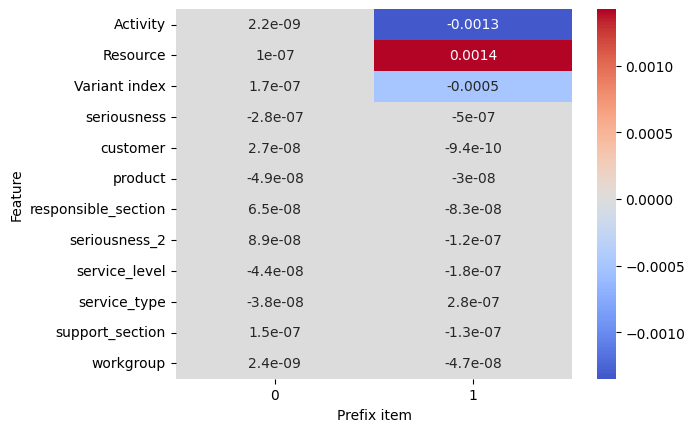

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                Variant index                         1.0   
                seriousness                          None   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day               30142.999905   
Mean Prediction Activity                   Resolve ticket   
                Resource                          Value 2   
                case_elapsed_time    [1476060.4956357887]   
                event_elapsed_time    [632980.7061246966]   

                                                Timestep 2  
Prefix          Activity             Take in charge ticket  
                Resource                           Value 4  
                Variant index                          1.0  
                seriousness                           None  
                customer                          Value 17  
                product                            Value 1  
                responsible_section                Value 1  
                seriousness_2                      Value 1  
                service_level                      Value 2  
                service_type                       Value 1  
                support_section                    Value 1  
                workgroup                          Value 1  
                case_elapsed_time               295.049276  
                event_elapsed_time              294.936142  
                day_in_week                            1.0  
                seconds_in_day                30438.000323  
Mean Prediction Activity                            Closed  
                Resource                           Value 5  
                case_elapsed_time       [3085465.98150302]  
                event_elapsed_time    [1549852.5758604093]

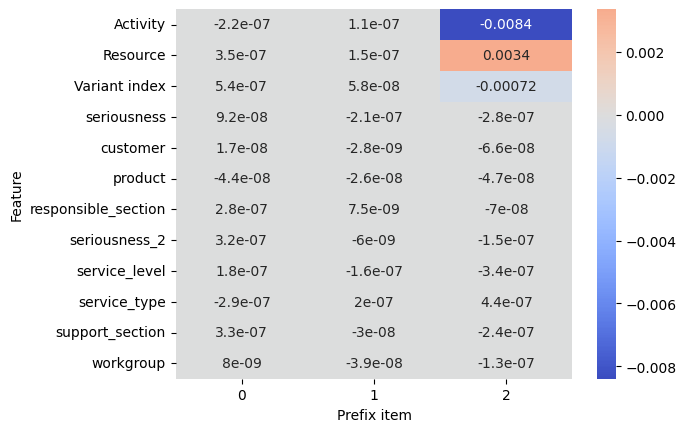

Timestep 1  \
Prefix          Activity               Assign seriousness   
                Resource                          Value 1   
                Variant index                         1.0   
                seriousness                          None   
                customer                         Value 17   
                product                           Value 1   
                responsible_section               Value 1   
                seriousness_2                     Value 1   
                service_level                     Value 2   
                service_type                      Value 1   
                support_section                   Value 1   
                workgroup                         Value 1   
                case_elapsed_time                0.070602   
                event_elapsed_time            963303.3125   
                day_in_week                           1.0   
                seconds_in_day               30142.999905   
Mean Prediction Activity                           Closed   
                Resource                          Value 5   
                case_elapsed_time    [3267555.5333097293]   
                event_elapsed_time   [1642288.5336263152]   

                                                Timestep 2      Timestep 3  
Prefix          Activity             Take in charge ticket  Resolve ticket  
                Resource                           Value 4         Value 4  
                Variant index                          1.0             1.0  
                seriousness                           None            None  
                customer                          Value 17        Value 17  
                product                            Value 1         Value 1  
                responsible_section                Value 1         Value 1  
                seriousness_2                      Value 1         Value 1  
                service_level                      Value 2         Value 2  
                service_type                       Value 1         Value 1  
                support_section                    Value 1         Value 1  
                workgroup                          Value 1         Value 1  
                case_elapsed_time               295.049276    12487.051993  
                event_elapsed_time              294.936142    12192.018077  
                day_in_week                            1.0             1.0  
                seconds_in_day                30438.000323    42630.000003  
Mean Prediction Activity                               NaN             NaN  
                Resource                               NaN             NaN  
                case_elapsed_time                      NaN             NaN  
                event_elapsed_time                     NaN             NaN

In [ ]:
from classes.event import Event, HelpdeskEvent
from classes.sequence import Sequence
from classes.suffix_samples import SuffixSamples
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def fetch_attributions(row):
    prefix_length = row.loc["prefix_len"]
    case_name = row.loc["case_name"]
    attribution_tensor = row.loc["attributions_case_elapsed_time"].squeeze(0)
    attribution_list = []
    for time_step in attribution_tensor[-prefix_length:]:

        attr = unpack_attribution(time_step[0])
        attribution_list.append(attr)
    

    return attribution_list, prefix_length, case_name


def unpack_attribution(sample_tensor):
    start_index = 0
    attribution_dict = {}

    for idx, encoded_attribute in enumerate(new_eval.prefix_cat_attributes):
        embedding_dim = new_eval.model.encoder.embeddings[idx].embedding_dim
        attribution_dict[encoded_attribute] = sample_tensor[start_index:start_index+embedding_dim].mean()
        start_index += embedding_dim

    return attribution_dict


def visualize_attribution(attribution_list, prefix_len, case_name, inference_results):
    # --- Attribution heatmap ---
    df_attr = pd.DataFrame(
        [{k: v.detach().item() for k, v in d.items()} for d in attribution_list]
    )
    sns.heatmap(df_attr.T, center=0, cmap="coolwarm", annot=True)
    plt.xlabel("Prefix item")
    plt.ylabel("Feature")
    plt.show()

    # --- Fetch corresponding inference row ---
    row = inference_results[
        (inference_results["prefix_len"] == prefix_len) &
        (inference_results["case_name"] == case_name)
    ]

    if row.empty:
        print("No prefix or mean prediction found for this row.")
        return

    prefix = row.iloc[0]["prefix"]
    mean_prediction = row.iloc[0]["mean_prediction"]

    # --- Prefix: list of dicts (one dict per timestep) ---
    df_prefix = pd.DataFrame(prefix).T
    df_prefix.columns = [f"Timestep {i+1}" for i in range(df_prefix.shape[1])]

    # --- Mean prediction: list of dicts (one dict per timestep) ---
    # unwrap scalar lists if needed
    cleaned_mean_pred = []
    for step in mean_prediction:
        cleaned_step = {
            k: (v[0] if isinstance(v, list) and len(v) == 1 else v)
            for k, v in step.items()
        }
        cleaned_mean_pred.append(cleaned_step)

    df_mean_pred = pd.DataFrame(cleaned_mean_pred).T
    df_mean_pred.columns = [f"Timestep {i+1}" for i in range(df_mean_pred.shape[1])]

    # --- Combine for display ---
    df_combined = pd.concat(
        [df_prefix, df_mean_pred],
        keys=["Prefix", "Mean Prediction"]
    )

    display(df_combined)



for idx, row in results_df.iterrows():
    attribution_list, prefix_length, case_name = fetch_attributions(row)
    visualize_attribution(attribution_list, prefix_length, case_name, inference_results)